# 第4章 Python による音声信号処理

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/r9y9/ttslearn/blob/master/notebooks/ch04_Python-SP.ipynb)

## 4.1 準備

### Python version

In [1]:
!python -VV

Python 3.7.11 (default, Jul 27 2021, 14:32:16) 
[GCC 7.5.0]


### ttslearn のインストール

In [2]:
%%capture
try:
    import ttslearn
except ImportError:
    !pip install ttslearn

In [3]:
import ttslearn
ttslearn.__version__

'0.2.2'

### ttslearn の動作確認

In [4]:
from ttslearn.dnntts import DNNTTS
from IPython.display import Audio

engine = DNNTTS()
wav, sr = engine.tts("日本語音声合成のデモです。")
Audio(wav, rate=sr)

The use of pre-trained models is permitted for non-commercial use only.
Please visit https://github.com/r9y9/ttslearn to confirm the license.
Downloading: "https://github.com/r9y9/ttslearn/releases/download/v0.2.0/dnntts.tar.gz"


dnntts.tar.gz: 0.00B [00:00, ?B/s]

Downloading: "https://github.com/r9y9/open_jtalk/releases/download/v1.11.1/open_jtalk_dic_utf_8-1.11.tar.gz"


dic.tar.gz: 0.00B [00:00, ?B/s]

Extracting tar file /home/vscode/.local/lib/python3.7/site-packages/pyopenjtalk/dic.tar.gz


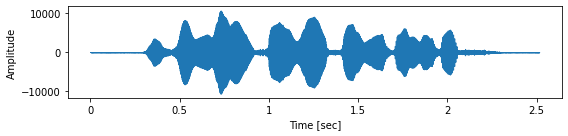

In [5]:
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8,2))
librosa.display.waveshow(wav.astype(np.float32), sr= sr, ax=ax)
ax.set_xlabel("Time [sec]")
ax.set_ylabel("Amplitude")
plt.tight_layout()

### パッケージのインポート

In [6]:
%pylab inline
%load_ext autoreload
%autoreload
import IPython
from IPython.display import Audio
import os

Populating the interactive namespace from numpy and matplotlib


In [7]:
# シードの固定
from ttslearn.util import init_seed
init_seed(1234)

### 描画周りの設定

In [8]:
from ttslearn.notebook import get_cmap, init_plot_style, savefig
cmap = get_cmap()
init_plot_style()

## 4.2 数値計算のためのPythonライブラリ

### NumPy と Torch を用いた配列の作成

In [9]:
import numpy as np
import torch

In [10]:
x = np.zeros((2,2), dtype=np.float32)
x

array([[0., 0.],
       [0., 0.]], dtype=float32)

In [11]:
y = torch.zeros(2,2, dtype=torch.float)
y

tensor([[0., 0.],
        [0., 0.]])

In [12]:
type(x)

numpy.ndarray

In [13]:
type(y)

torch.Tensor

### numpy.ndarray と torch.Tensor のインタフェースの違い

In [14]:
# Numpy では配列のサイズを tuple で与えます
x = np.zeros((1,2,3), dtype=np.float32)
x

array([[[0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

In [15]:
# PyTorch では配列のサイズを別々の引数で与えられます
y = torch.zeros(1, 2, 3, dtype=torch.float32)
y

tensor([[[0., 0., 0.],
         [0., 0., 0.]]])

In [16]:
x.shape == y.shape

True

### numpy.ndarray と torch.Tensor の相互変換

In [17]:
x = np.zeros((2,2), dtype=np.float32)

In [18]:
y = torch.zeros((2,2), dtype=torch.float32)

In [19]:
# torch.Tensor から numpy.ndarray への変換
type(y.numpy())

numpy.ndarray

In [20]:
# numpy.ndarray から torch.Tensor への変換
type(torch.from_numpy(x))

torch.Tensor

### numpy.ndarray と torch.Tensor のメモリ共有

In [21]:
x = np.zeros((2,2), dtype=np.float32)
x

array([[0., 0.],
       [0., 0.]], dtype=float32)

In [22]:
y = torch.from_numpy(x)
y

tensor([[0., 0.],
        [0., 0.]])

In [23]:
x[0,0] = 1.0 # メモリが共有されているため、 x への変更は y にも反映されます

In [24]:
x

array([[1., 0.],
       [0., 0.]], dtype=float32)

In [25]:
y

tensor([[1., 0.],
        [0., 0.]])

## 4.3 音声ファイルの読み込み

### scipy.io.wavfile を利用した音声ファイルの読み込み

In [26]:
from scipy.io import wavfile
import ttslearn

In [27]:
sr, wav = wavfile.read(ttslearn.util.example_audio_file())

In [28]:
sr

48000

In [29]:
wav.shape

(153120,)

In [30]:
len(wav) / sr

3.19

In [31]:
wav

array([  74,   47,   17, ..., -144, -143, -144], dtype=int16)

In [32]:
type(wav)

numpy.ndarray

### 音声の可視化

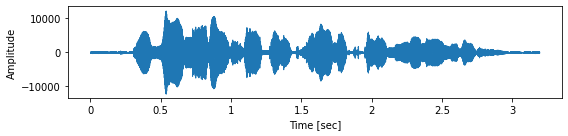

In [33]:
import librosa.display
import matplotlib.pyplot as plt

# 音声ファイルの読み込み
sr, x = wavfile.read(ttslearn.util.example_audio_file())

fig, ax = plt.subplots(figsize=(8,2))
librosa.display.waveshow(x.astype(np.float32),sr= sr, ax=ax)

ax.set_xlabel("Time [sec]")
ax.set_ylabel("Amplitude")
plt.tight_layout()

# 図4-2
savefig("fig/pyssp_waveshow")

# オーディオプレイヤーの表示
Audio(x.astype(np.float32), rate=sr)

## 4.4 音声のフーリエ変換

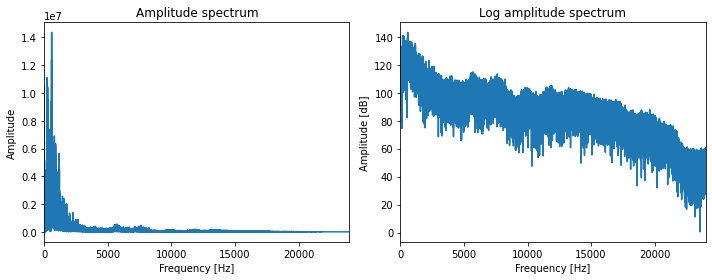

In [34]:
# 音声ファイルの読み込み
sr, x = wavfile.read(ttslearn.util.example_audio_file())
# 振幅スペクトル
X = np.abs(np.fft.rfft(x))
# 対数振幅スペクトル
logX = 20*np.log10(X)

fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
freq = np.arange(len(X)) / 2 / len(X) * sr
ax[0].plot(freq, X)
ax[0].set_title("Amplitude spectrum")
ax[0].set_xlim(0, sr // 2)
ax[0].set_xlabel("Frequency [Hz]")
ax[0].set_ylabel("Amplitude")

ax[1].plot(freq, logX)
ax[1].set_title("Log amplitude spectrum")
ax[1].set_xlabel("Frequency [Hz]")
ax[1].set_ylabel("Amplitude [dB]")
plt.tight_layout()

# 図4-3
savefig("fig/pyssp_rfftplot")

## 4.5 音声の短時間フーリエ変換とその逆変換

### 窓関数

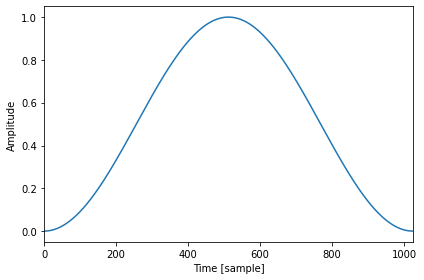

In [35]:
N = 1024
n = np.arange(N)
w = 0.5 - 0.5 * np.cos(2*np.pi * n / N)

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(w)
ax.set_xlim(0, N)
ax.set_xlabel("Time [sample]")
ax.set_ylabel("Amplitude")
plt.tight_layout()

### 短時間フーリエ変換の実装

In [36]:
def hanning(N):
    n = np.arange(N)
    w = 0.5 - 0.5 * np.cos(2*np.pi * n / N)
    return w

def stft(x, N, S):
    # 窓関数（簡単のため、窓幅とフレーム長 N は同じとします）
    w = hanning(N)
    # 短時間フーリエ変換のフレーム数
    M = (len(x) - N) // S + 1
    # 短時間フーリエ変換の結果格納用の 2 次元配列
    X = np.zeros((M, N//2 + 1), dtype=complex)
    # 音声をずらして切り出し、フーリエ変換
    for m in range(M):
        x_m = w * x[m*S:m*S+N]
        X[m, :] = np.fft.rfft(x_m)
    return X

### 短時間フーリエ変換の結果の可視化

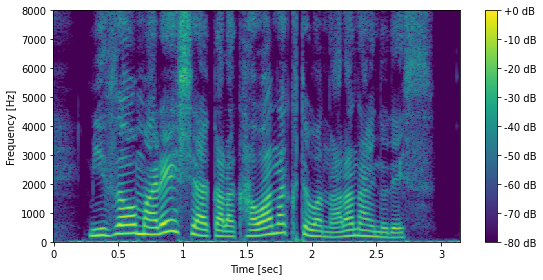

In [37]:
# 音声ファイルの読み込み
sr, x = wavfile.read(ttslearn.util.example_audio_file())

# 5 ミリ秒のフレームシフトを考えます
frame_shift = int(sr * 0.005)
n_fft = 2048
# スペクトログラム
X = stft(x.astype(np.float32), n_fft, frame_shift)
# 対数振幅に変換
logX = librosa.amplitude_to_db(np.abs(X), ref=np.max)

fig, ax = plt.subplots(1, 1, figsize=(8,4), sharex=True)
img = librosa.display.specshow(logX.T, hop_length=frame_shift, sr=sr, cmap=cmap, x_axis="time", y_axis="hz", ax=ax)
fig.colorbar(img, ax=ax, format="%+2.f dB")
# 音声のパワーは低域に集中するため、8000 Hz までを表示する
ax.set_ylim(0, 8000)

ax.set_xlabel("Time [sec]")
ax.set_ylabel("Frequency [Hz]")
plt.tight_layout()

# 図4-5
savefig("fig/pyssp_stft_example")

### librosa.stft を用いた短時間フーリエ変換

librosa.stftは、STFTを実行する前にデフォルトで信号の冒頭と末尾にパディング処理を行います。前述のSTFT実装はこの処理をサポートしていないため、同等のSTFTの結果を得るためには、center=Falseとしてパディング処理を行わないように設定します。

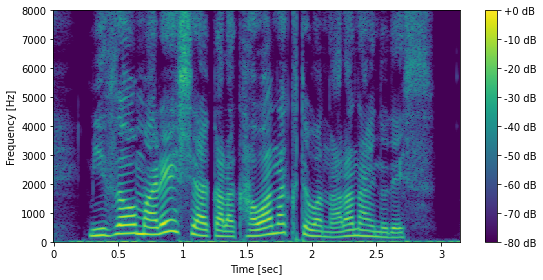

In [38]:
import librosa

# n_fft: 2048, frame_shift: 240
X = librosa.stft(x.astype(np.float32), n_fft=n_fft, win_length=n_fft, hop_length=frame_shift, window="hann", center=False).T
# 対数振幅に変換
logX = librosa.amplitude_to_db(np.abs(X), ref=np.max)

fig, ax = plt.subplots(1, 1, figsize=(8,4), sharex=True)
img = librosa.display.specshow(logX.T, hop_length=frame_shift, sr=sr, cmap=cmap, x_axis="time", y_axis="hz", ax=ax)
fig.colorbar(img, ax=ax, format="%+2.f dB")
# 音声のパワーは低域に集中するため、8000 Hz までを表示する
ax.set_ylim(0, 8000)

ax.set_xlabel("Time [sec]")
ax.set_ylabel("Frequency [Hz]")
plt.tight_layout()

### 時間解像度と周波数解像度のトレードオフ

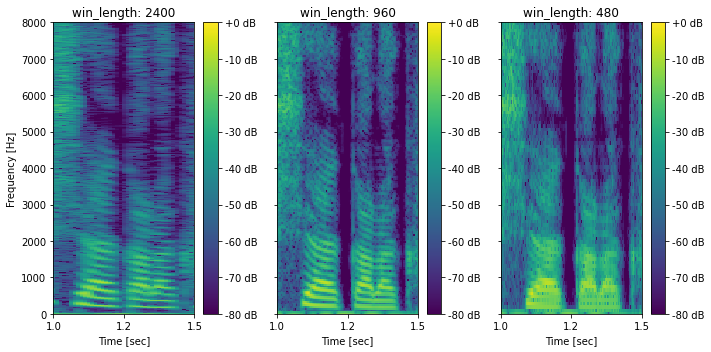

In [39]:
def next_power_of_2(x):
    return 1 if x == 0 else 2**(x - 1).bit_length()

fig, ax = plt.subplots(1, 3, figsize=(10,5), sharex=True, sharey=True)

for idx, win_length_ms in enumerate([0.05, 0.02, 0.01]):
    win_length = int(sr * win_length_ms)
    frame_shift = win_length // 4
    n_fft = next_power_of_2(win_length)
    
    X = librosa.stft(x.astype(np.float32), n_fft=n_fft, win_length=n_fft, hop_length=frame_shift).T
    logX =  librosa.amplitude_to_db(np.abs(X), ref=np.max)
    mesh = librosa.display.specshow(
        logX.T, hop_length=frame_shift, sr=sr, cmap=cmap, x_axis="time", y_axis="hz", ax=ax[idx])
    fig.colorbar(mesh, ax=ax[idx], format="%+2.f dB")
    ax[idx].set_title(f"win_length: {win_length}")
    mesh.set_clim(-80, 0)
    ax[idx].set_xlim(1.0, 1.5)
    ax[idx].set_xticks([1.0, 1.25, 1.5])
    # あとでラベルを付け直すので、ここでは消しておく
    ax[idx].set_ylabel("")

ax[0].set_ylabel("Frequency [Hz]")
for a in ax:
    a.set_xlabel("Time [sec]")
    a.set_ylim(0, 8000)
    a.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.tight_layout()

# 図4-6
savefig("fig/pyssp_stft_tradeoff")

### 逆短時間フーリエ変換による音声の復元

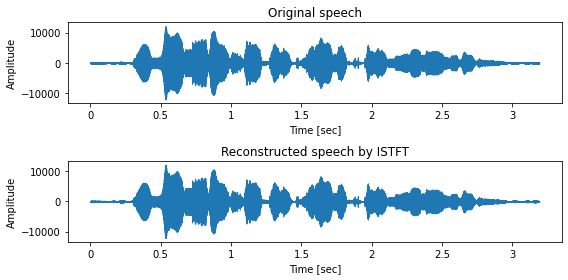

In [40]:
# 音声ファイルの読み込み
sr, x = wavfile.read(ttslearn.util.example_audio_file())
# 5 ミリ秒のフレームシフトを考えます
frame_shift = int(sr * 0.005)
n_fft = 2048

# STFT
X = librosa.stft(x.astype(np.float32), n_fft=n_fft, win_length=n_fft, hop_length=frame_shift, window="hann")
# ISTFT
x_hat = librosa.istft(X, win_length=n_fft, hop_length=frame_shift, window="hann")

IPython.display.display(Audio(x.astype(np.float32), rate=sr))
IPython.display.display(Audio(x_hat.astype(np.float32), rate=sr))

fig, ax = plt.subplots(2, 1, figsize=(8,4), sharey=True)
ax[0].set_title("Original speech")
ax[1].set_title("Reconstructed speech by ISTFT")
librosa.display.waveshow(x.astype(np.float32), sr=sr, ax=ax[0])
librosa.display.waveshow(x_hat.astype(np.float32),sr= sr, ax=ax[1])

for a in ax:
    a.set_xlabel("Time [sec]")
    a.set_ylabel("Amplitude")
plt.tight_layout()

## 4.6 メルスペクトログラム

### メルフィルタバンク

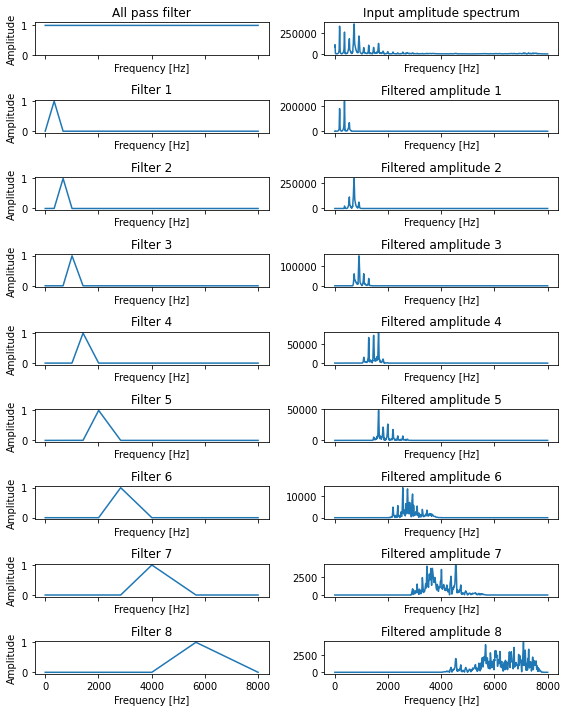

In [44]:
sr = 16000
n_fft = 2048
n_mels = 8

# 音声ファイルの読み込み
sr, x = wavfile.read(ttslearn.util.example_audio_file())
x = x.astype(np.float32)
x = librosa.resample(x, orig_sr=sr, target_sr=16000)
sr = 16000

# 5 ミリ秒のフレームシフトを考えます
frame_shift = int(sr * 0.005)
# STFT
X = librosa.stft(
    x, n_fft=n_fft, win_length=n_fft, hop_length=frame_shift, window="hann"
)
# 1 フレームを切り出す
X_m = np.abs(X[:, 280])

# メルフィルタバンク: n_mels 個のフィルタから構成されます
melfb = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels, norm=None)
freq = librosa.fft_frequencies(sr=sr, n_fft=n_fft)

# メルフィルタバンクを表示
fig, ax = plt.subplots(n_mels + 1, 2, figsize=(8, 10), sharex=True)
ax[0][0].plot(freq, np.ones_like(freq))
ax[0][0].set_title("All pass filter")
ax[0][0].set_ylim(0, 1.1)
ax[0][1].plot(freq, X_m)
ax[0][1].set_title("Input amplitude spectrum")
for idx, fb in enumerate(melfb):
    ax[idx + 1][0].plot(freq, fb)
    ax[idx + 1][0].set_title(f"Filter {idx+1}")
    ax[idx + 1][1].plot(freq, fb * X_m)
    ax[idx + 1][1].set_title(f"Filtered amplitude {idx+1}")

for a, b in ax:
    a.set_xlabel("Frequency [Hz]")
    b.set_xlabel("Frequency [Hz]")
    a.set_ylabel("Amplitude")
plt.tight_layout()

# 図4-7
savefig("fig/pyssp_melfb")

### メルスペクトログラムの計算

(1025, 639) (80, 639)


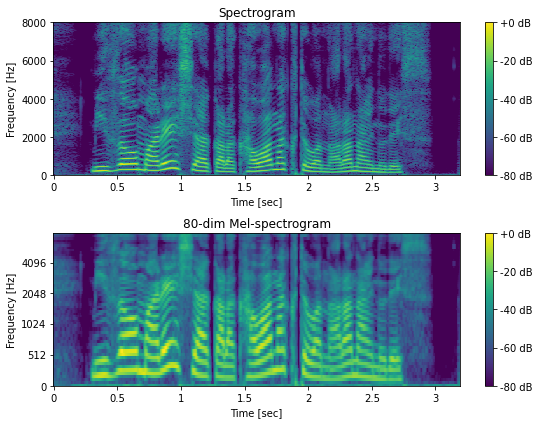

In [47]:
# 音声ファイルの読み込み
sr, x = wavfile.read(ttslearn.util.example_audio_file())
# 5 ミリ秒のフレームシフトを考えます
frame_shift = int(sr * 0.005)
n_fft = 2048

# スペクトログラム
X = librosa.stft(x.astype(np.float32), n_fft=n_fft, hop_length=frame_shift)

# 80 次元のメルスペクトログラム
n_mels = 80
melfb = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)
melspec = librosa.amplitude_to_db(np.dot(melfb, np.abs(X)), ref=np.max)

print(X.shape,melspec.shape,melfb.shape)

# 比較用の対数振幅スペクトログラム
logX = librosa.amplitude_to_db(np.abs(X), ref=np.max)

fig, ax = plt.subplots(2, 1, figsize=(8, 6))
ax[0].set_title("Spectrogram")
ax[1].set_title("80-dim Mel-spectrogram")
mesh = librosa.display.specshow(
    logX, hop_length=frame_shift, sr=sr, cmap=cmap, x_axis="time", y_axis="hz", ax=ax[0]
)
fig.colorbar(mesh, ax=ax[0], format="%+2.f dB")
mesh.set_clim(-80, 0)
mesh = librosa.display.specshow(
    melspec,
    hop_length=frame_shift,
    sr=sr,
    cmap=cmap,
    x_axis="time",
    y_axis="mel",
    ax=ax[1],
)
fig.colorbar(mesh, ax=ax[1], format="%+2.f dB")
mesh.set_clim(-80, 0)

for a in ax:
    a.set_ylim(0, 8000)
    a.set_xlabel("Time [sec]")
    a.set_ylabel("Frequency [Hz]")
plt.tight_layout()

# 図4-8
savefig("fig/pyssp_melspectrogram")

## 4.6 Griffin-Lim のアルゴリズムに基づく位相復元

In [ ]:
# 音声ファイルの読み込み
sr, x = wavfile.read(ttslearn.util.example_audio_file())
# 5 ミリ秒のフレームシフトを考えます
frame_shift = int(sr * 0.005)
n_fft = 2048

# 振幅スペクトログラム
X = np.abs(librosa.stft(x.astype(np.float32), n_fft=n_fft, hop_length=frame_shift))

y1 = librosa.griffinlim(X, hop_length=frame_shift, n_iter=1)
y2 = librosa.griffinlim(X, hop_length=frame_shift, n_iter=100)

# オーディオプレイヤーの表示
IPython.display.display(Audio(y1, rate=sr))
IPython.display.display(Audio(y2, rate=sr))
IPython.display.display(Audio(x, rate=sr))

fig, ax = plt.subplots(3, 1, figsize=(8,6), sharey=True)
ax[0].set_title("Griffin-Lim # of iteration: 1")
ax[1].set_title("Griffin-Lim # of iteration: 100")
ax[2].set_title("Natural speech")
librosa.display.waveshow(y1, sr=sr, ax=ax[0])
librosa.display.waveshow(y2, sr=sr, ax=ax[1])
librosa.display.waveshow(x.astype(np.float32), sr=sr, ax=ax[2])

for a in ax:
    a.set_xlabel("Time [sec]")
    a.set_ylabel("Amplitude")
plt.tight_layout()

# 図4-9
savefig("fig/pyssp_griffin_lim")

### 瞬時周波数の可視化 (bonus)

Griffin-Limのアルゴリズムは、位相復元手法です。合成音声と自然音声の瞬時位相（位相の時間微分）を比較することで、位相復元が期待通り行われているかを視覚的に確認できます。

In [ ]:
n_fft = 1024
hop_length = n_fft // 4
fig, ax = plt.subplots(1, 3, figsize=(10,5), sharex=True)

C = librosa.stft(y1, n_fft=n_fft, hop_length=hop_length)
ifreq = np.angle(C[:, 1:] * np.conjugate(C[:, :-1]))
mesh = librosa.display.specshow(ifreq, cmap=cmap, ax=ax[0], x_axis="time", y_axis="hz", sr=sr, hop_length=hop_length)
fig.colorbar(mesh, ax=ax[0])
ax[0].set_title("GL # of iteration: 1")

C = librosa.stft(y2, n_fft=n_fft, hop_length=hop_length)
ifreq = np.angle(C[:, 1:] * np.conjugate(C[:, :-1]))
mesh = librosa.display.specshow(ifreq, cmap=cmap, ax=ax[1], x_axis="time", y_axis="hz", sr=sr, hop_length=hop_length)
fig.colorbar(mesh, ax=ax[1])
ax[1].set_title("GL # of iteration: 100")

C = librosa.stft(x.astype(np.float32), n_fft=n_fft, hop_length=hop_length)
ifreq = np.angle(C[:, 1:] * np.conjugate(C[:, :-1]))
mesh = librosa.display.specshow(ifreq, cmap=cmap, ax=ax[2], x_axis="time", y_axis="hz", sr=sr, hop_length=hop_length)
fig.colorbar(mesh, ax=ax[2])
ax[2].set_title("Natural speech")

for a in ax:
    # あとでラベルを付け直すので、ここでは消しておく
    a.set_ylabel("")

ax[0].set_ylabel("Frequency [Hz]")
for a in ax:
    a.set_xlim(1.5, 3.0)
    a.set_ylim(0, 4000)
    a.set_xlabel("Time [sec]")
    a.set_xticks([1.5, 2.0, 2.5, 3.0])
    
plt.tight_layout()